# 3k2f 60 C High Pressure

We are repeating the measurement of the 3k2f PPG polyol at 60 C to extend our data set to higher pressure in search of interesting supercritical behaviors. Along the way we will repeat a few data points at lower pressures to assess the repeatability of measurements. The experiment was performed with manual pressure changes and used DataThief on the plot generated by the Belsorp BG software to extra gravimetry data. 

The polyol is difunctional with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from July 15-24, 2019.
    
The analysis computes the **solubility, interfacial tension, and specific volume** of the sample at pressures from 0 to 80 bar at 60 C. No diffusivity data are provided because of the lack of reliable time-series data at either the beginning or the end of the sorption curve due to large fluctuations in temperature (which have a magnified effect at higher pressure).

We begin by importing the required Python libraries and setting parameters for this particular analysis.

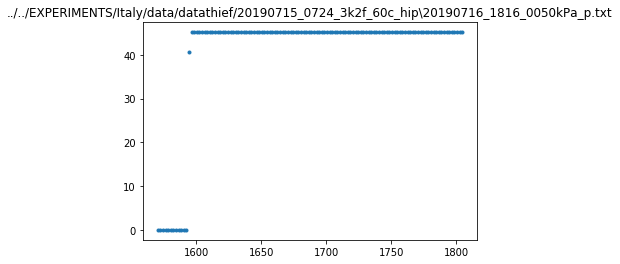

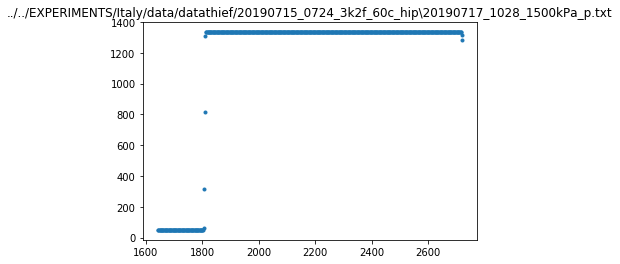

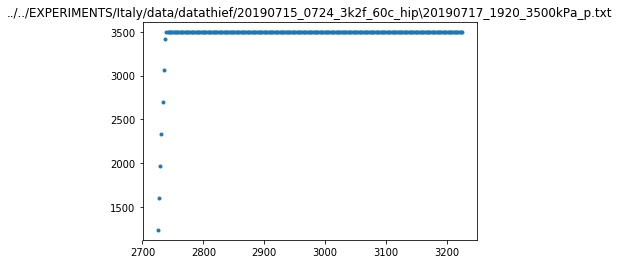

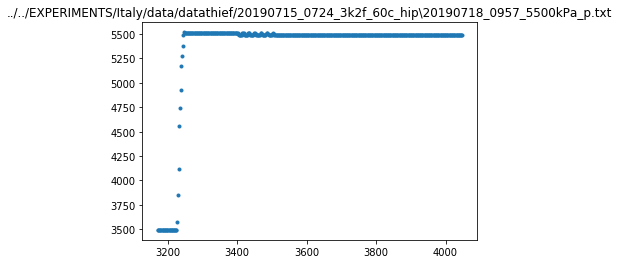

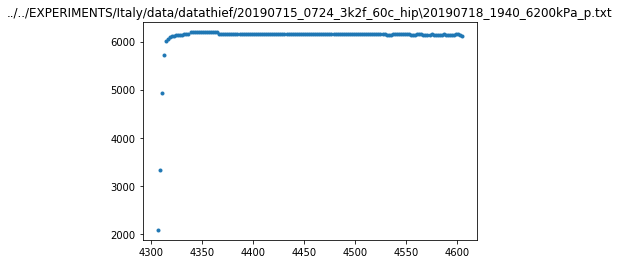

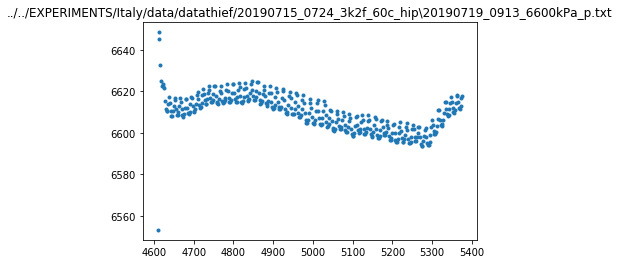

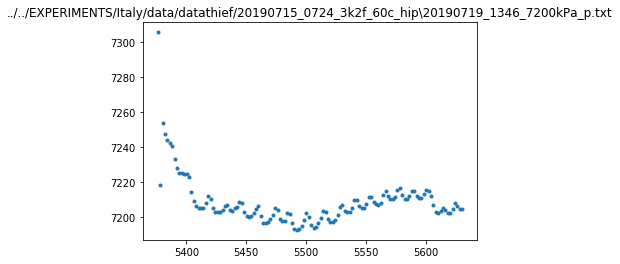

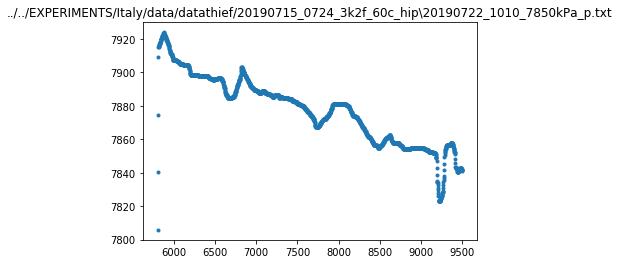

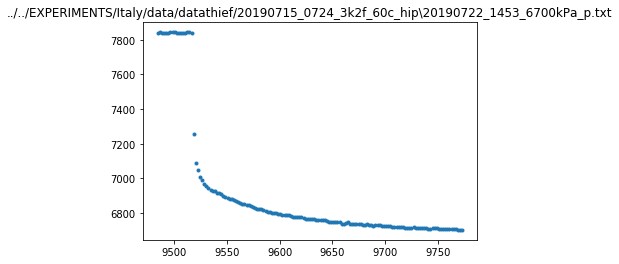

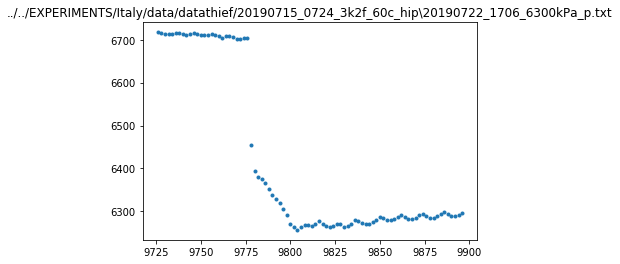

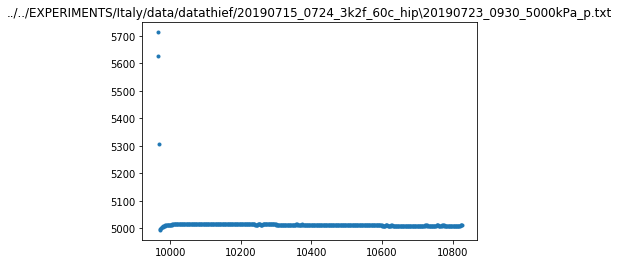

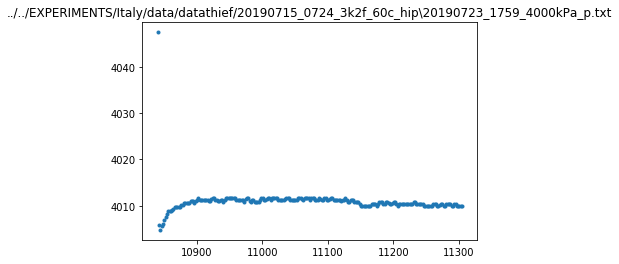

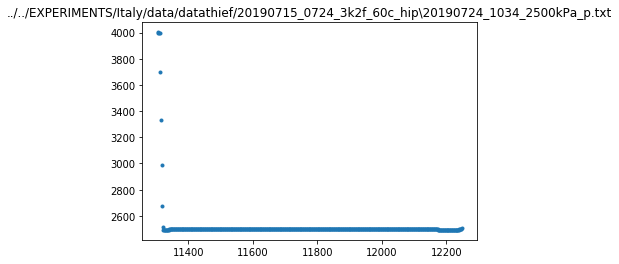

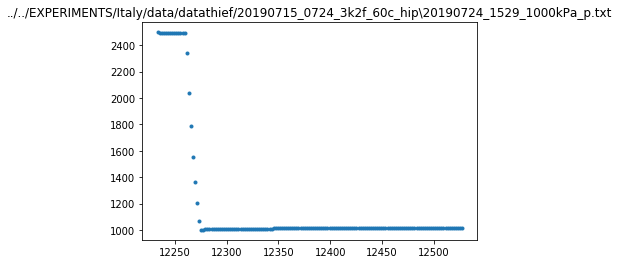

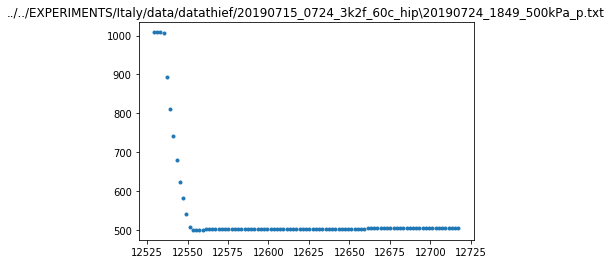

In [5]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import glob
import os
from scipy.interpolate import interp1d

import dataproc
from timedate import TimeDate

from importlib import reload
reload(dataproc)

file_template = '201907*_*_*kPa*'
metadata_file = '20190715_0724_3k2f_60c_hip_metadata.txt'
# folder for gravimetry data from DataThief analysis of Belsorp BG data plotted from Rubotherm
datathief_folder = '../../EXPERIMENTS/Italy/data/datathief/20190715_0724_3k2f_60c_hip/'
grav_folder = '../../EXPERIMENTS/Italy/data/gravimetry/'
date_ref = '7/15/2019'
time_ref = '12:00:00'
# system parameters
polyol = '3k2f'
T = 60
i_50kPa = 0

p_filepath_template = os.path.join(datathief_folder + file_template + '_p.txt')
p_file_list = glob.glob(p_filepath_template)
T_filepath_template = os.path.join(datathief_folder + file_template + '_T.txt')
T_file_list = glob.glob(T_filepath_template)
mp1_filepath_template = os.path.join(datathief_folder + file_template + '_mp1.txt')
mp1_file_list = glob.glob(mp1_filepath_template)

# initialize numpy arrays to store measured values (time,pressure, temperature, and MP1 balance reading)
t_grav = []
p_list = []
T_list = []
br_list = []
bp_list = []
time_list = []
date_list = []
# load metadata
metadata = pd.read_csv(datathief_folder + metadata_file, header=0)

# create reference date and time object
time_date_ref = TimeDate()
time_date_ref.load_string(date_ref, time_ref)
# load data from each file
for i in range(len(p_file_list)):
    # extract filepaths for pressure, temperature, and MP1 balance reading
    p_file = p_file_list[i]
    T_file = T_file_list[i]
    mp1_file = mp1_file_list[i]
    # load data
    t_p, p = dataproc.load_datathief_data(p_file)
    t_T, T_ = dataproc.load_datathief_data(T_file)
    t_mp1, mp1 = dataproc.load_datathief_data(mp1_file)
    # remove repeats and interpolate values so spacing is even
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2)
       
    # identify pressure step as a reference point in time to synchronize different runs
    t_shift = dataproc.compute_t_shift(metadata, i, t_p_interp, p_interp, p_file, date_ref, time_ref)
        
    # synchronize times of all measurements using only times that overlap
    t_min = np.max([np.min(t_p), np.min(t_T), np.min(t_mp1)])
    t_max = np.min([np.max(t_p), np.max(t_T), np.max(t_mp1)])
    # remove repeats and interpolate values so spacing is even (all interpolated times should be the same)
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2, t_min=t_min, t_max=t_max)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2, t_min=t_min, t_max=t_max)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2, t_min=t_min, t_max=t_max)
    
    # shift time
    t_p_interp += t_shift
    
    # concatenate data
    zero_last = i != i_50kPa # accidentally took zero measurement first for 50 kPa
    dataproc.concatenate_data(metadata, i, date_ref, time_ref, time_list, date_list, 
                     t_grav, t_p_interp, p_interp, p_list, T_interp, T_list, 
                     mp1_interp, br_list, bp_list, zero_last=zero_last)
    
# save results in TRD file format
df_trd = pd.DataFrame(columns=['DATE', 'TIME', 'Julabo_Ext_PV', 'WEITGHT(g)', 'BALANCE POSITION', 'Now Pressure(kPa)'])
df_trd['DATE'] = date_list
df_trd['TIME'] = time_list
df_trd['Julabo_Ext_PV'] = T_list
df_trd['WEITGHT(g)'] = br_list
df_trd['BALANCE POSITION'] = bp_list
df_trd['Now Pressure(kPa)'] = p_list
trd_save_hdr = grav_folder + '%s_%dc-TRD-071519-1200' % (polyol, T)

# save csv file with TRD header
dataproc.save_trd(df_trd, trd_save_hdr)

Having created an artificial TRD file in the format that would have been produced by the Belsorp program during an automatic test, we can now proceed through the analysis as usual.

In [6]:
import errprop
import plot

reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/20190715_0724_3k2f_hip/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190716_0717_3k2f_60c_hip_adsa_volume.csv', '20190718_0719_3k2f_60c_hip_adsa_volume.csv',
                        '20190719_3k2f_60c_hip_adsa_volume.csv', '20190719_0720_3k2f_60c_hip_adsa_volume.csv',
                        '20190722_3k2f_60c_hip_adsa_volume.csv', '20190722_0723_3k2f_60c_hip_adsa_volume.csv',
                        '20190723_0724_3k2f_60c_hip_adsa_volume.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = []
# filepath to gravimetry data 
grav_filepath = trd_save_hdr + '.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '3k2f_60c_hip.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 7/15 13:04; adsa videos: 14:27, 7/16; 19:18, 7/17; 14:14, 7/18; 9:16, 7/19; 16:48, 7/19
adsa_time_list = ['14:27:00', '19:18:00', '14:14:00', '9:16:00', '16:48:00', '10:02:00', '18:15:00', '16:02:00', '15:35:00']
adsa_date_list = ['7/16/2019', '7/17/2019', '7/18/2019', '7/19/2019', '7/19/2019', '7/22/2019', '7/22/2019', 
                  '7/23/2019', '7/24/2019']
# number of measurements to average for surface tension and volume readings
n_adsa = 50

# polyol code name
polyol = '3k2f_hip'
# weight of sample in atmospheric pressure, measured with analytical balance on 7/5/19 [g]
w_samp_atm = 1.1153
# volume of drop in atmospheric pressure, from 20190716_3k2f_60c_atm_snapshot.mdb [uL]
v_drop_atm = 4.136
# volume of drop under vacuum, from 20190716_3k2f_60c_0bar_snapshot.mdb [uL]
v_drop_0 = 4.116
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS)
# and extrapolated using P-1000 Dow data [g/mL]
rho_samp_atm = 0.977
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]
# measurements made manually with Rubotherm on 7/16/19 at 60 C
mp1_atm = 14.02994
zero_atm = 5.63404
# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = metadata['p set [kPa]'].to_numpy(dtype=float)
p_set_arr[0] = 45
p_set_arr[1] = 1330
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# resolution o pressure measurement [kPa]
p_resolution = 1
# number of measurements of pressure within equilibrium (2 min per measurement --> 30 minutes, 2-3 cycles of temperature,
# which fluctuated every 10-15 minutes.)
n_p_eq = 15

# CONSTANTS
# Set-point temperature [C]
T = 60
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + dataproc.rho_co2(P_ATM, T)*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

We first compute the time delay from the reference time of the experiment (roughly the beginning) to the beginning of each ADSA measurement.

In [7]:
# initialize list of time delays until the start of the ADSA measurements
adsa_t0_list = []
# use TimeDate class to compute seconds of delay between the times and dates provided
for i in range(len(adsa_time_list)):
    adsa_time = adsa_time_list[i]
    adsa_date = adsa_date_list[i]
    adsa_td = TimeDate()
    adsa_td.load_string(adsa_date, adsa_time)
    # compute seconds after reference time that ADSA was started
    adsa_t0_list += [TimeDate.diff_min(time_date_ref, adsa_td)*60]

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [8]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, _, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, 
                                                                      adsa_t0_list, grav_filepath, p_set_arr, zero_t_grav=False)
t_adsa /= 60
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 45 kPa.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


no adsa data for current pressure.
Pressure = 1330 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 3500 kPa.
no adsa data for current pressure.
Pressure = 5500 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 6200 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 6600 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 7200 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 7850 kPa.
7850.0
0.01
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 6700 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 6300 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 5000 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 4000 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 2500 kPa.
Rejected 1 outliers.
no adsa data for current pressure.
Pressure = 1000 kPa.
Rejected 1 outliers.
no adsa 

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,45.0,45.1745,1,5.63332,1e-05,14.0265,0.000104563,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,1333.33,1,5.61248,1e-05,13.9403,0.0024269,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,3496.92,1,5.57332,1e-05,13.7926,0.00424616,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,5493.83,1,5.52911,1e-05,13.6342,0.00389989,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,6146.03,10.8789,5.51185,1e-05,13.515,0.00643523,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


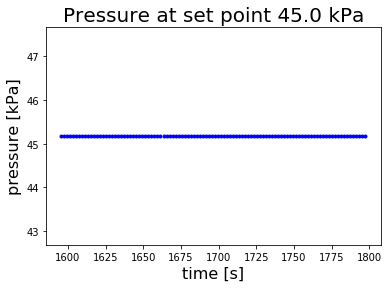

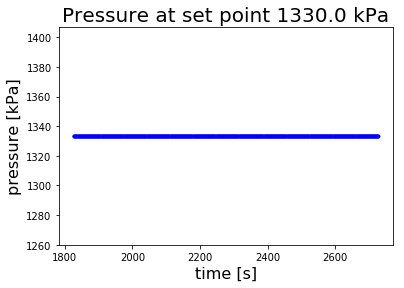

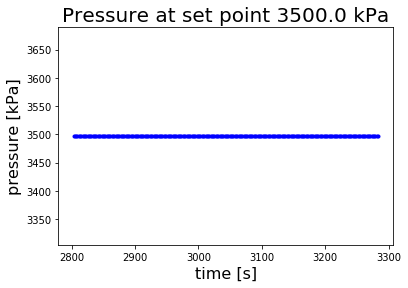

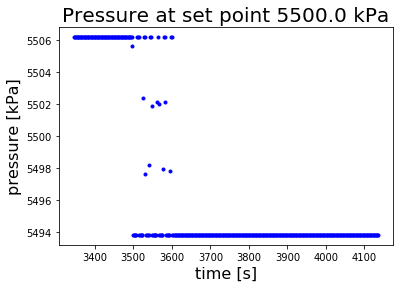

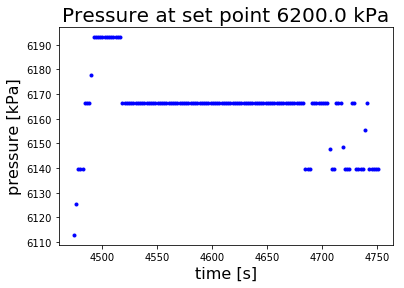

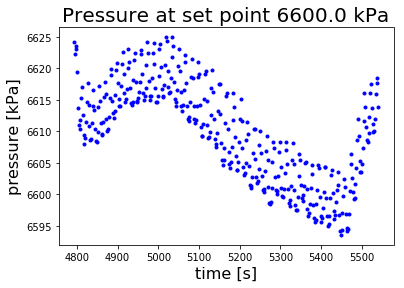

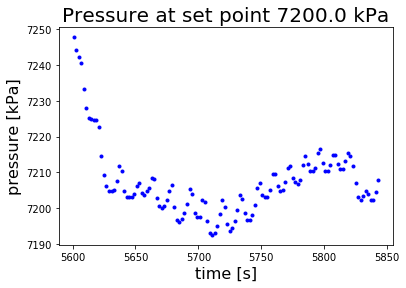

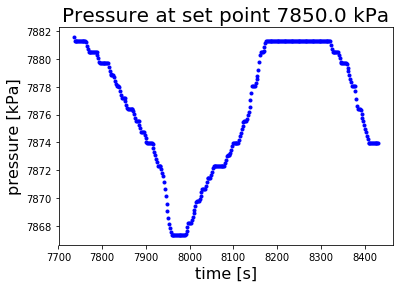

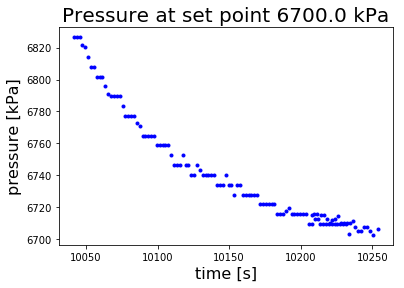

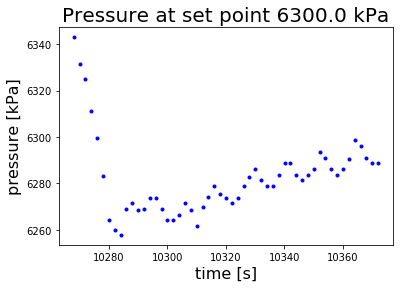

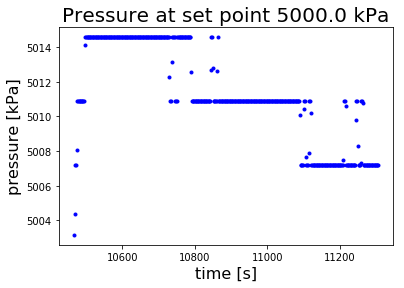

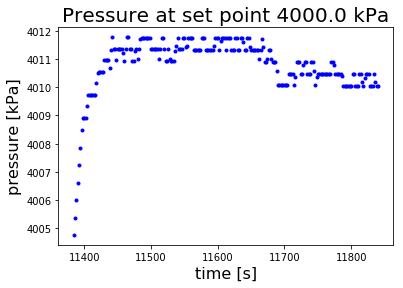

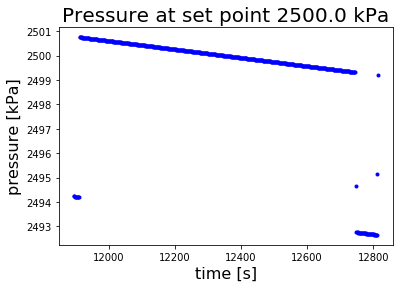

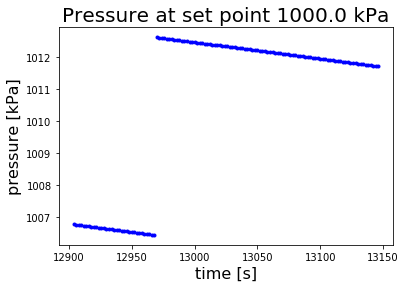

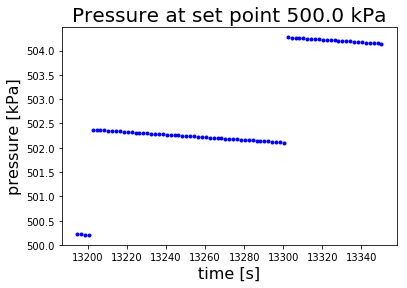

In [9]:
reload(dataproc)
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
focus_on_step = False
select_index = 10
plot_p = True
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    if p_set == np.max(p_set_arr):
        window_reduction = 0.01
        print(p_set)
        print(window_reduction)
    else:
        window_reduction = 0.25
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1, window_reduction=window_reduction)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = max(np.std(p_eq), p_resolution)

    if focus_on_step:
        i_p -= 20
        
        if i != select_index:
            continue
    if plot_p:
        # PLOT PRESSURE TO DEBUG IDENTIFICATION OF PRESSURE STEPS
        plot.plot_line(t_grav[i_p0:i_p1], p_arr[i_p0:i_p1], xlabel='time [s]', ylabel='pressure [kPa]',
                 title='Pressure at set point {0} kPa'.format(p_set))
        if focus_on_step:
            ax.set_xlim([220000, 250000])
            ax.set_ylim([4800, 4950])

    # store results in data frame
    df = dataproc.store_grav_adsa_manual(df, metadata, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_adsa, n_p_eq)

df.head()

Because the volume measurements seem inaccurate, I will test by examining what should be the correct volume measurements for individual pressures. I start with 45 kPa (50 kPa).

In [10]:
# measurement at 45 kPa taken from 14:34 7/16 to 18:18 7/17
# take measurements of volume from 16:00-18:00 7/17
# how many minutes is that after the reference time?
td_45_start = TimeDate()
td_45_start.load_string('7/17/2019', '16:00:00')
delay_45 = TimeDate.diff_min(time_date_ref, td_45_start)
print(delay_45)

# how many minutes into 20190716_0717_...adsa_volume is this?
td_adsa_45 = TimeDate()
td_adsa_45.load_string(adsa_date_list[0], adsa_time_list[0])
delay_adsa_45 = TimeDate.diff_min(td_adsa_45, td_45_start)
print(delay_adsa_45*60)
print('seconds after start of 20190716_0717....csv')
# this includes entries 158-170, which have an average of 4.42 uL, which is way above the 
# value computed by the program (around 4.1-4.2 uL)

3120
91980
seconds after start of 20190716_0717....csv


## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum. Since I did not take a measurement with the balance under vacuum, I will extrapolate the balance reading using measurements made at atmospheric pressure and 50 kPa, assuming a linear change in the balance reading at such low pressures.

In [11]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# balance reading at atmospheric pressure made before starting the tests
br_eq_atm = mp1_atm - zero_atm
# (extract value at 50 kPa) [g]
br_eq_50kPa = br_eq[0]
# extrapolate balance reading at 0 kPa assuming Henry's Law [g]
br_eq_0 = br_eq_50kPa - 50*(br_eq_atm - br_eq_50kPa)/(P_ATM - 50)
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere by subtracting extrapolated balance reading at 0 kPa
w_gas_atm = (br_eq_atm - br_eq_0) + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 1.104463 g vs. mass of polymer at atmospheric pressure = 1.115300 g.
Dry polymer mass estimated using tare measurement = 1.1084063460186417 g.
Volume of dry polymer in crucible is approximately ~ 1.136036 mL (using atmospheric density).


### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

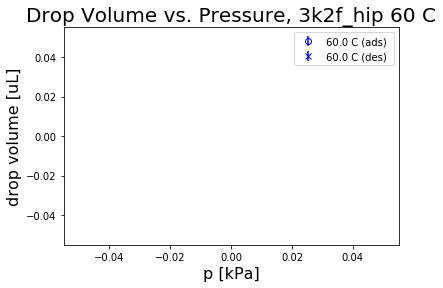

In [12]:
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
s_drop_vol = df['drop volume std [uL]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))

if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

In [ ]:
# from scipy.interpolate import interp1d

# # initialize arrays for data
# t_grav = np.array([])
# p_arr = np.array([])
# T_arr = np.array([])
# # br_arr = np.array([])
# bp_arr = np.array([])

# # load and store gravimetry data obtained using DataThief from the graphs in the Belsorp BG program
# for i in range(len(grav_file_hdr_list)):
#     grav_file_hdr = grav_file_hdr_list[i]
#     p_data = np.genfromtxt(grav_folder + grav_file_hdr + '_p.txt', delimiter=',')
#     t_p  = p_data[:, 0]
#     p = p_data[:, 1]
#     T_data = np.genfromtxt(grav_folder + grav_file_hdr + '_T.txt', delimiter=',')
#     t_T  = T_data[:, 0]
#     T = T_data[:, 1]
#     mp1_data = np.genfromtxt(grav_folder + grav_file_hdr + '_mp1.txt', delimiter=',')
#     t_mp1  = mp1_data[:, 0]
#     mp1 = mp1_data[:, 1]

#     # synchronize using interpolations within overlapping times
#     t_min = int(np.max(np.array([t_p[0], t_T[0], t_mp1[0]]))) + 1
#     t_max = int(np.min(np.array([t_p[-1], t_T[-1], t_mp1[-1]])))
    
#     # concatenate data
#     t_grav = np.concatenate((t_grav, t_interp))
#     p_arr = np.concatenate((p_arr, p_interp))
#     T_arr = np.concatenate((T_arr, T_interp))
#     br_arr = np.concatenate((br_arr, mp1_interp))
#     # indicate that the balance position is mp1 (2)
#     bp_arr = np.concatenate((bp_arr, 2*np.ones([len(br_arr)])))
    
#     # collate data, add a final data point for the zero measurement
#     zero_data_pts = zero_data[i, :]
#     t_zero = zero_data_pts[0]
#     p_zero = zero_data_pts[1]
#     T_zero = zero_data_pts[2]
#     zero = zero_data_pts[3]
#     # assume that the conditions were the same as at the end for the zero point
#     t_grav = np.concatenate((t_grav, np.array([t_zero])))
#     p_arr = np.concatenate((p_arr, np.array([p_zero])))
#     T_arr = np.concatenate((T_arr, np.array([T_zero])))
#     br_arr = np.concatenate((br_arr, np.array([zero])))
#     # indicate that for the zero measurement, the balance point is 1
#     bp_arr = np.concatenate((bp_arr, np.array([1])))
    


In [ ]:
t_mp1